## 트위터 감성 분석

> 참고한 노트북 : https://www.kaggle.com/code/tanulsingh077/twitter-sentiment-extaction-analysis-eda-and-model <br>
데이터 셋 : https://www.kaggle.com/competitions/tweet-sentiment-extraction/data


In [1]:
import re
import os
import nltk
import spacy
import string
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.io as pio
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
%matplotlib inline

from plotly import graph_objs as go
from collections import Counter

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from nltk.corpus import stopwords

from tqdm import tqdm
from spacy.util import compounding, minibatch

warnings.filterwarnings('ignore')
pio.renderers.default = 'notebook_connected'

In [2]:
def random_colors(num_of_colors: int) -> list:
    '''
    랜덤한 컬러를 생성하는 함수입니다. \n
    Input: \n
        num_of_colors - 생성할 색상 수를 나타내는 정수 값. \n
    Output: \n
        다음과 같은 format을 return합니다: ['#E86DA4']
    '''

    colors = []
    for _ in range(num_of_colors):
        colors.append("#"+''.join([random.choice('0123456789ABCDEF') for _ in range(6)]))
    
    return colors

## 데이터 살펴보기


In [3]:
train = pd.read_csv("./data/train.csv")
test = pd.read_csv("./data/test.csv")
ss = pd.read_csv("./data/sample_submission.csv")

In [4]:
print(train.shape)
print(test.shape)

(27481, 4)
(3534, 3)


훈련셋에는 27,481건의 데이터가, 테스트 셋에는 3,534건의 데이터가 존재합니다.

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


text와 selected_text 컬럼에 결측치가 한 개씩 존재하는 것을 확인할 수 있습니다.

In [6]:
train.dropna(inplace=True)  # 결측치 제거

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27480 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27480 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27480 non-null  object
dtypes: object(4)
memory usage: 1.0+ MB


혹여나 빈 문자열들은 없는지 확인합니다.

In [8]:
train.loc[train.text == ""]

,textID,text,selected_text,sentiment


In [9]:
train.loc[train.selected_text == ""]

,textID,text,selected_text,sentiment


In [10]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


테스트 셋에는 결측치가 존재하지 않습니다.

## EDA


In [11]:
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


selected_text의 경우 text의 일부임을 확인할 수 있습니다.

<hr style="height: 1px;">

In [12]:
train.describe().T.style.background_gradient(cmap="Purples")

,count,unique,top,freq
textID,27480,27480,cb774db0d1,1
text,27480,27480,"I`d have responded, if I were going",1
selected_text,27480,22463,good,199
sentiment,27480,3,neutral,11117


트윗 게시글의 분포를 살펴봅시다.

In [13]:
temp = train.groupby('sentiment').count()['text'].reset_index().sort_values(by='text', ascending=False)
temp.style.background_gradient(cmap="Purples")

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


In [14]:
fig = px.histogram(x="sentiment", data_frame=train, color='sentiment')
fig.update_layout(width=800, height=600)
fig.update_yaxes(tickformat=",")
fig.show()

In [15]:
funnel = go.Figure(go.Funnelarea(
    text=temp.sentiment,
    values = temp.text,
    title = {"position": "top center", "text": "Funnel-Chart of Sentiment Distribution"}
))

funnel.show()

### Funnel Chart

펀넬 차트의 경우 판매 프로세스의 단계를 나타내고 각 단계의 잠재적 수익 금액을 표시하는 데 자주 사용되는 차트 유형입니다.

<hr style="height: 1px;">

## Jaccard
여태까지 여러 가지 유사성을 사용해보았지만, 자카드 유사성은 처음 보기에 정리를 약간 해본다.

### 자카드 유사성

두 집합 사이의 similarity를 측정하는 방법 중 하나. 0 ~ 1 사이의 값을 가지며 두 집합이 동일하면 1의 값을 가지고, 공통 원소가 없으면 0을 가진다.

$$ J(A, B) = {{ |{A\cap B}| }\over { |{A\cup B}| }} = {{ |{A\cap B}| }\over { |A| + |B| - { |{A\cap B}| }}}$$


In [16]:
def jaccard(str1: str, str2: str):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)  # 교집합

    return float(len(c)) / (len(a) + len(b) - len(c))

In [17]:
results_jaccard = []

for idx, row in train.iterrows():  # iterrows : 행 인덱스, 컬럼들을 리턴한다.
    sentence1 = row['text']
    sentence2 = row['selected_text']

    jaccard_score = jaccard(sentence1, sentence2)
    results_jaccard.append([sentence1, sentence2, jaccard_score])

In [18]:
jaccard_df = pd.DataFrame(results_jaccard, columns=['text', 'selected_text', 'jaccard_score'])
train = train.merge(jaccard_df, how='outer')  # 모든 행을 포함하는 외부(outer)조인

In [19]:
train

,textID,text,selected_text,sentiment,jaccard_score
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,negative,0.200000
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,positive,0.166667
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,negative,0.222222
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,neutral,0.666667
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,positive,0.181818
...,...,...,...,...,...
27475,1b54db957d,zoombezi bay was soooo fun!! buuuut my legs ar...,zoombezi bay was soooo fun!! buuuut my legs ar...,neutral,1.000000
27476,79a3f22848,{cont} that right their is why fake btches sho...,excite me,positive,0.105263
27477,a38b466046,~ Happy Star Wars Day.every one ~ ...may the ...,Happy Star Wars Day.every one,positive,0.416667
27478,cc4a151d1d,"ï¿½anisalovesu me too. I am so so upset,especi...","lovesu me too. I am so so upset,especially bec...",neutral,0.875000


In [20]:
train['Num_words_ST'] = train['selected_text'].apply(lambda x : len(str(x).split()))  # selected_text 안에 있는 단어의 개수
train['Num_words_text'] = train['text'].apply(lambda x : len(str(x).split()))  # text안에 있는 단어의 개수
train['difference_in_words'] = train['Num_words_text'] - train['Num_words_ST']  # 위 두 컬럼을 뺀 값

In [21]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_text,difference_in_words
0,0fab80d6b2,\tREALLY?? oh.. sorry yall lol,sorry,negative,0.200000,1,5,4
1,8106d4c6fa,_beckett Thanks so much !,beckett Thanks,positive,0.166667,2,5,3
2,3792c7b13e,You`ll be missed!! Bring me back a key...,You`ll be miss,negative,0.222222,3,8,5
3,b58a92fe10,get lit I am http://bit.ly/OASQR,get lit I am http://bit.ly/,neutral,0.666667,5,5,0
4,18180bb2ec,Good morning to you ! Its so pretty outs...,Its so pr,positive,0.181818,3,10,7


In [22]:
hist_data = [train['Num_words_ST'], train['Num_words_text']]

group_labels = ['Selected_Text', 'Text']

new_fig = ff.create_distplot(hist_data, group_labels, show_curve=False)
new_fig.update_layout(title_text='Distribution of Number of Words')
new_fig.update_layout(
    autosize=False,
    width=900,
    height=700,
    paper_bgcolor="LightSteelBlue"
)

new_fig.show()

방금 생성한 컬럼 중 selected_text의 단어수와 text의 단어수에 대한 히스토그램이다. 단어의 수가 25보다 큰 트윗이 매우 적은 편이어서 right skewness한 모습을 보여준다.

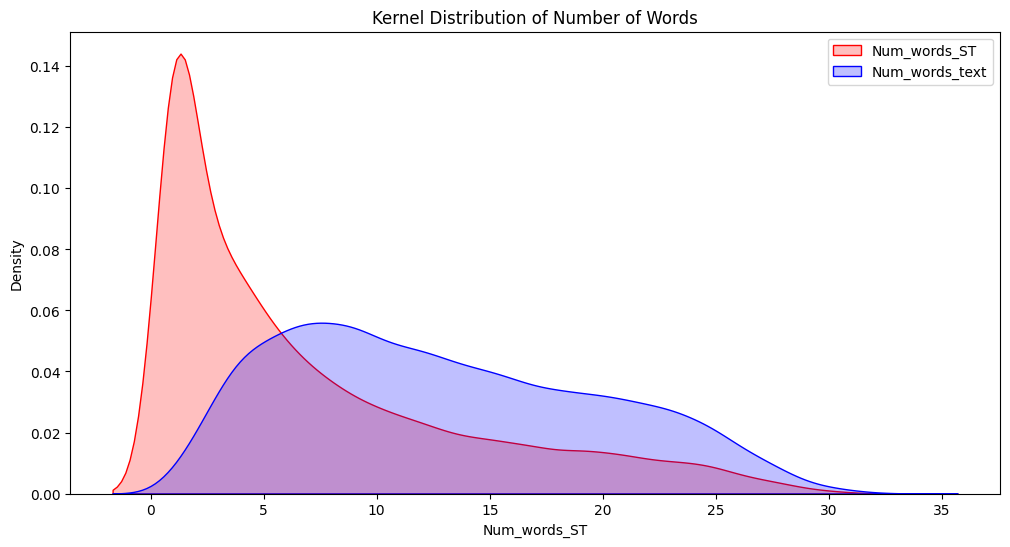

In [23]:
plt.figure(figsize=(12, 6))
p1 = sns.kdeplot(train['Num_words_ST'], shade=True, color='r').set_title('Kernel Distribution of Number of Words')
p2 = sns.kdeplot(train['Num_words_text'], shade=True, color='b')

plt.legend(labels=['Num_words_ST', 'Num_words_text'])

이제 단어 수와 jaccard_score간의 관계를 보겠습니다.

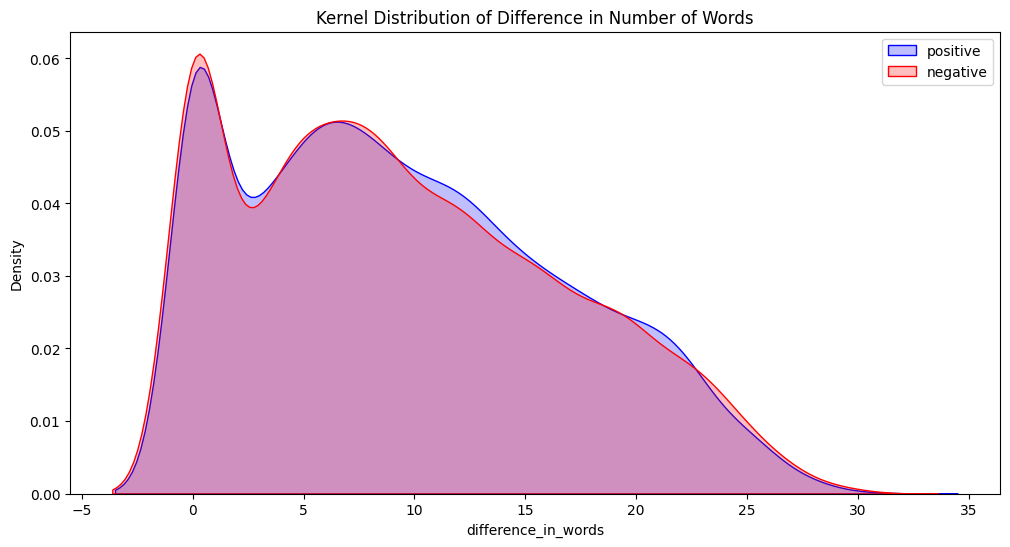

In [24]:
plt.figure(figsize=(12, 6))
p1 = sns.kdeplot(
    train[train['sentiment']=="positive"]['difference_in_words'], 
    shade=True, 
    color='b'
    ).set_title('Kernel Distribution of Difference in Number of Words')

p2 = sns.kdeplot(
    train[train['sentiment']=='negative']['difference_in_words'], 
    shade=True,
    color='r')

plt.legend(labels=['positive', 'negative'])

<Figure size 1200x600 with 0 Axes>

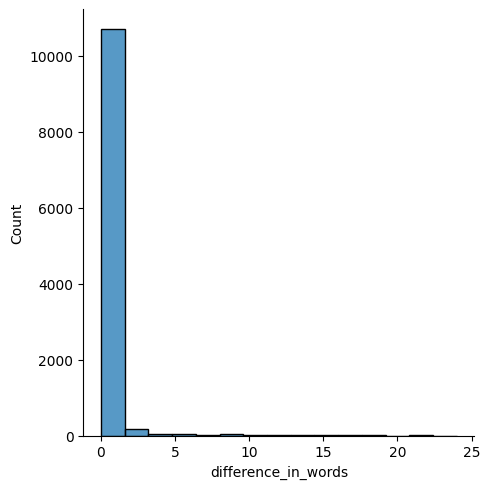

In [25]:
plt.figure(figsize=(12, 6))
sns.displot(train[train['sentiment']=='neutral']['difference_in_words'], kde=False)

중립 트윗에 대한 kde 플롯의 경우 단어 수 차이에 대한 값이 대부분 0이었기에 시각화를 할 수 없었습니다.

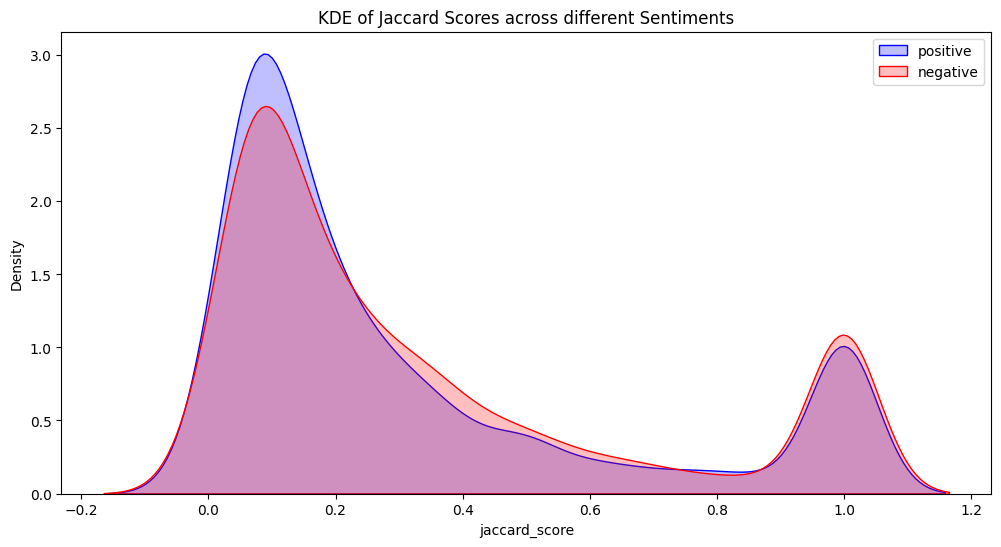

In [26]:
plt.figure(figsize=(12, 6))
p1 = sns.kdeplot(
    train[train['sentiment']=='positive']['jaccard_score'],
    shade=True, color='b'
).set_title('KDE of Jaccard Scores across different Sentiments')

p2 = sns.kdeplot(
    train[train['sentiment']=='negative']['jaccard_score'],
    shade=True, color='r'
)

plt.legend(labels=['positive', 'negative'])

jaccard score와 관련된 시각화도 중립 트윗들은 시각화할 수 없습니다.

<Figure size 1200x600 with 0 Axes>

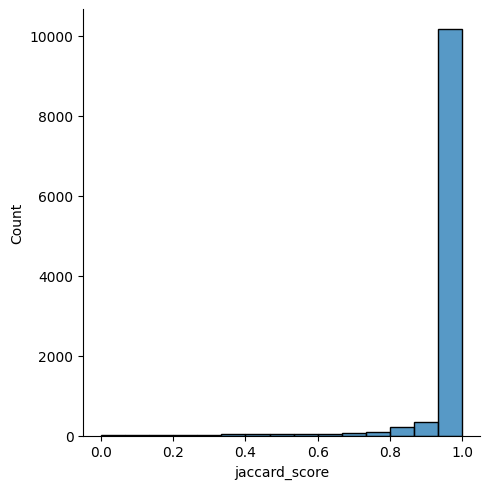

In [27]:
plt.figure(figsize=(12, 6))
sns.displot(train[train['sentiment']=='neutral']['jaccard_score'], kde=False)

이제 여기서 trends를 살펴볼 수 있습니다.
- 긍정 트윗과 부정 트윗은 첨도가 높아 값이 좁고 밀도가 높은 두 지역에 집중됩니다.
- 중립 트윗은 첨도 값이 낮고 밀도가 1에 가깝습니다.

※ 참고
- 첨도는 분포가 정규 분포보다 얼마나 뾰족하거나 완만한지의 정도를 나타내는 척도이다. 
- 왜도는 곡선이 정규 분포에서 벗어나는 정도를 나타내는 척도이다.

## EDA 결론
- jaccard_score 그림에서 1점 부근에서 부정적인 그림과 긍정적인 그림에 대한 피크가 있음을 알 수 있습니다. 즉, text와 selected_text 사이에 유사성이 높은 트윗 클러스터가 있음을 의미합니다. 이러한 클러스터를 찾을 수 있다면 세그먼트에 관계없이 해당 트윗에 대한 선택된 텍스트의 텍스트를 예측할 수 있습니다.



In [28]:
k = train[train['Num_words_text'] <= 2]
k.groupby('sentiment')['jaccard_score'].mean()

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

In [29]:
k[k['sentiment']=='positive']

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_text,difference_in_words
100,3ff9947935,**** right!,**** right!,positive,1.0,2,2,0
151,d2f915b8c7,Good Morning!,Good,positive,0.5,1,2,1
154,b4fa2d20e4,Good one,Good one,positive,1.0,2,2,0
155,5714d8c2c3,Goodnight.,Goodnight,positive,0.0,1,1,0
334,6d9bd35d32,Thank you,Thank,positive,0.5,1,2,1
...,...,...,...,...,...,...,...,...
26454,0ccac3f8b7,sweet situations.,sweet situations.,positive,1.0,2,2,0
26484,6475ddf649,thanks,thanks,positive,1.0,1,1,0
26499,274181e2e2,thanx,thanx,positive,1.0,1,1,0
26933,28fc81d56a,wants cookie,wants cookie,positive,1.0,2,2,0


## 데이터 정제


In [30]:
def clean_text(text):
    '''
    문자를 소문자로 바꾸고, 쓸데없는 문자들을 제거한다.
    '''

    text = str(text).lower()
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("[%s]"%re.escape(string.punctuation), "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)

    return text

In [31]:
train['text'] = train['text'].apply(lambda x: clean_text(x))
train['selected_text'] = train['selected_text'].apply(lambda x : clean_text(x))

In [32]:
train.head()

,textID,text,selected_text,sentiment,jaccard_score,Num_words_ST,Num_words_text,difference_in_words
0,0fab80d6b2,\treally oh sorry yall lol,sorry,negative,0.200000,1,5,4
1,8106d4c6fa,beckett thanks so much,beckett thanks,positive,0.166667,2,5,3
2,3792c7b13e,youll be missed bring me back a keychain,youll be miss,negative,0.222222,3,8,5
3,b58a92fe10,get lit i am,get lit i am,neutral,0.666667,5,5,0
4,18180bb2ec,good morning to you its so pretty outsi...,its so pr,positive,0.181818,3,10,7


## Most Common words in Selected Text

In [33]:
train['temp_list'] = train['selected_text'].apply(lambda x: str(x).split())
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap="Blues")

,Common_words,count
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


In [34]:
fig = px.bar(temp, x="count", y="Common_words", title="Common Words in Selected Text", orientation='h', width=700, height=700, color="Common_words")

fig.show()

In [37]:
def remove_stopword(x):
    return [y for y in x if y not in stopwords.words('english')]

train['temp_list'] = train['temp_list'].apply(lambda x : remove_stopword(x))

In [38]:
top = Counter([item for sublist in train['temp_list'] for item in sublist])
temp = pd.DataFrame(top.most_common(20))
temp = temp.iloc[1:, :]
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap="Purples")

,Common_words,count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [39]:
fig = px.treemap(temp, path=['Common_words'], values='count', title='Tree of Most Common Words')
fig.show()

## Most Common Words in Text


In [40]:
train['temp_list1'] = train['text'].apply(lambda x: str(x).split())
train['temp_list1'] = train['temp_list1'].apply(lambda x: remove_stopword(x))

In [41]:
top = Counter([item for sublist in train['temp_list1'] for item in sublist])
temp = pd.DataFrame(top.most_common(25))
temp = temp.iloc[1:, :]
temp.columns = ['Common_words', 'count']
temp.style.background_gradient(cmap="Blues")

,Common_words,count
1,day,2044
2,good,1549
3,get,1426
4,like,1346
5,go,1267
6,dont,1200
7,love,1122
8,work,1112
9,today,1096
10,going,1096


In [42]:
fig = px.bar(temp, x='count', y='Common_words', title="Common Words in Text", orientation='h', width=700, height=700, color='Common_words')
fig.show()

## Most common words Sentiments Wise

In [43]:
Positive_sent = train[train['sentiment']=='positive']
Negative_sent = train[train['sentiment']=='negative']
Neutral_sent = train[train['sentiment']=='neutral']

In [44]:
top = Counter([item for sublist in Positive_sent['temp_list'] for item in sublist])
temp_positive = pd.DataFrame(top.most_common(20))
temp_positive.columns = ['Common_words', 'count']
temp_positive.style.background_gradient(cmap='Greens')

,Common_words,count
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [45]:
fig = px.bar(temp_positive, x="count", y="Common_words", title="Most Common Positive Words", orientation='h', width=700, height=700, color="Common_words")
fig.show()

In [46]:
top = Counter([item for sublist in Negative_sent['temp_list'] for item in sublist])
temp_negative = pd.DataFrame(top.most_common(20))
temp_negative = temp_negative.iloc[1:, :]
temp_negative.columns = ['Common_words', 'count']
temp_negative.style.background_gradient(cmap='Reds')

,Common_words,count
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162
10,sucks,159


In [47]:
fig = px.treemap(temp_negative, path=['Common_words'], values='count', title='Tree Of Most Common Negative Words')
fig.show()